<h1 style="text-align: center; font-weight: bold;">Data Sciense Course - Spring 1403</h1>
<h1 style="text-align: center; font-weight: bold;">Project Phase2 - Introduction to Data Science </h1>
<h1 style="text-align: center;">Mohammadreza Mohammadhashemi : 810100206</h1>
<h1 style="text-align: center;">Soheil Hajian Manesh : 810100119</h1>
<h1 style="text-align: center;">Mahdi Ebrahimi Soltani : 810100241</h1>

# Problem Description
In this phase of our project, we training machine learning models and evaluate them to predict the target variables.

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
from tabulate import tabulate
from colorama import Fore
import tensorflow as tf
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier,IsolationForest
from sklearn.preprocessing import StandardScaler,LabelEncoder
from sklearn.impute import KNNImputer , SimpleImputer
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import mutual_info_regression
from sklearn.metrics import r2_score , mean_squared_error
from sklearn.neighbors import KNeighborsRegressor
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam

In [3]:
df = pd.read_csv('EDA_df.csv')

# Part 1 & 2: Preprocessing and Feature Engineering Selection

for preprocessing part, we do most of data cleaning in previous part but still something left for this part.       
we first handling missing values for each column.For some columns that have very low percent missing, only drop rows with missing value.For other columns fill missing value using Random Forest Classifire model.      
we also detect and drop outliers using Issolation Forest Model and encode categorical columns using LabelEncoder.

In [4]:
def print_null_values(df):
    null_counts = df.isnull().sum()
    total_rows = len(df)
    null_percentages = (null_counts / total_rows) * 100

    result_df = pd.DataFrame({
        'Column Name': null_counts.index,
        'Null Count': null_counts,
        'Null Percentage': null_percentages
    })

    colored_rows = []
    for i, (_, row) in enumerate(result_df.iterrows()):
        if row['Null Count'] > 0:
            color = Fore.RED
        else:
            color = Fore.WHITE if i % 2 == 0 else Fore.LIGHTWHITE_EX
        colored_row = [
            f"{color}{row['Column Name']}",
            f"{color}{row['Null Count']}",
            f"{color}{row['Null Percentage']:.2f}%",
        ]
        colored_rows.append(colored_row)

    headers = [Fore.CYAN + "Column Name", Fore.CYAN + "Null Count", Fore.CYAN + "Null Percentage"]
    print(tabulate(colored_rows, headers=headers, tablefmt='fancy_grid', numalign='right'))

In [5]:
print_null_values(df)

╒══════════════════════╤══════════════╤═══════════════════╕
│ Column Name          │   Null Count │ Null Percentage   │
╞══════════════════════╪══════════════╪═══════════════════╡
│ Category             │            0 │ 0.00%             │
├──────────────────────┼──────────────┼───────────────────┤
│ Field                │            0 │ 0.00%             │
├──────────────────────┼──────────────┼───────────────────┤
│ Seller Level         │           36 │ 0.40%             │
├──────────────────────┼──────────────┼───────────────────┤
│ Seller In Same Level │            0 │ 0.00%             │
├──────────────────────┼──────────────┼───────────────────┤
│ Basic Price          │            0 │ 0.00%             │
├──────────────────────┼──────────────┼───────────────────┤
│ Standard Price       │            0 │ 0.00%             │
├──────────────────────┼──────────────┼───────────────────┤
│ Premium Price        │            0 │ 0.00%             │
├──────────────────────┼──────────────┼─

In [6]:
df.dropna(subset=['Country'], inplace=True)
print_null_values(df)

╒══════════════════════╤══════════════╤═══════════════════╕
│ Column Name          │   Null Count │ Null Percentage   │
╞══════════════════════╪══════════════╪═══════════════════╡
│ Category             │            0 │ 0.00%             │
├──────────────────────┼──────────────┼───────────────────┤
│ Field                │            0 │ 0.00%             │
├──────────────────────┼──────────────┼───────────────────┤
│ Seller Level         │           36 │ 0.40%             │
├──────────────────────┼──────────────┼───────────────────┤
│ Seller In Same Level │            0 │ 0.00%             │
├──────────────────────┼──────────────┼───────────────────┤
│ Basic Price          │            0 │ 0.00%             │
├──────────────────────┼──────────────┼───────────────────┤
│ Standard Price       │            0 │ 0.00%             │
├──────────────────────┼──────────────┼───────────────────┤
│ Premium Price        │            0 │ 0.00%             │
├──────────────────────┼──────────────┼─

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9000 entries, 0 to 9000
Data columns (total 39 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Category              9000 non-null   object 
 1   Field                 9000 non-null   object 
 2   Seller Level          8964 non-null   float64
 3   Seller In Same Level  9000 non-null   int64  
 4   Basic Price           9000 non-null   float64
 5   Standard Price        9000 non-null   float64
 6   Premium Price         9000 non-null   float64
 7   Basic Delivery        9000 non-null   int64  
 8   Standard Delivery     9000 non-null   int64  
 9   Premium Delivery      9000 non-null   int64  
 10  Basic Revision        9000 non-null   int64  
 11  Standard Revision     9000 non-null   int64  
 12  Premium Revision      9000 non-null   int64  
 13  Rating                8784 non-null   float64
 14  Rating Count          9000 non-null   float64
 15  Country               9000

In [8]:
def encode_and_save_mappings(df, file_name='column_mappings.txt'):

    df_encoded = df.copy()
    mappings = []

    with open(file_name, 'w') as f:
        for column in df_encoded.select_dtypes(include=['object', 'category']).columns:
            le = LabelEncoder()

            non_null_values = df_encoded[column].dropna()
            le.fit(non_null_values)

            df_encoded[column] = df_encoded[column].apply(lambda x: le.transform([x])[0] if pd.notnull(x) else x)

            mapping = {original: encoded for original, encoded in zip(le.classes_, le.transform(le.classes_))}
            mappings.append({column: mapping})

            f.write(f"Column: {column}\n")
            for original, encoded in mapping.items():
                f.write(f"{original} -> {encoded}\n")
            f.write("\n")

    for mapping in mappings:
        for column, mapping_values in mapping.items():
            print(f"Column: {column}")
            for original, encoded in mapping_values.items():
                print(f"{original} -> {encoded}")
            print()

    return df_encoded

In [9]:
df['Member Since'] = pd.to_datetime(df['Member Since'])
df['Member Since'] = (datetime.now() - df['Member Since']).dt.days

In [10]:
languages = ['Arabic' , 'Bengali', 'Chinese', 'Dutch', 'English', 'French', 'German', 'Hindi', 'Indonesian', 'Italian', 'Portuguese', \
           'Punjabi', 'Russian', 'Spanish', 'Turkish', 'Ukrainian', 'Urdu']

In [11]:
df['Spoken Languages Count'] = df[languages].sum(axis=1)

In [12]:
df_labeled = encode_and_save_mappings(df)

Column: Category
Business -> 0
Data -> 1
Digital Marketing -> 2
Graphics & Design -> 3
Lifestyle -> 4
Music & Audio -> 5
Photography -> 6
Programming & Tech -> 7
Video & Animation -> 8
Writing & Translation -> 9

Column: Field
3d-product-animation -> 0
animated-explainer-videos -> 1
articles-blogposts -> 2
book-editing -> 3
business-plans -> 4
chatbots -> 5
data-analactics -> 6
data-engineering -> 7
data-mining -> 8
data-processing -> 9
data-science -> 10
databases -> 11
digital-illustration -> 12
dj-mixing -> 13
event-photographers -> 14
fashion-design -> 15
financial-consulting-services -> 16
fitness -> 17
food-photographers -> 18
game-art -> 19
game-development -> 20
influencer-marketing -> 21
legal-consulting-services -> 22
life-coaching -> 23
lifestyle-fashion-photographers -> 24
logo-animation-services -> 25
market-research-reports -> 26
mixing-mastering -> 27
mobile-app-services -> 28
modeling-acting -> 29
nft -> 30
online-tutoring -> 31
online-video-marketing -> 32
personal-sty

In [13]:
def impute_with_random_forest(df, columns_to_impute):

    df_imputed = df.copy()
    imputer = SimpleImputer(strategy='most_frequent')

    for target_column in columns_to_impute:
        if df_imputed[target_column].isnull().sum() == 0:
            continue

        df_not_missing = df_imputed.dropna(subset=[target_column])
        df_missing = df_imputed[df_imputed[target_column].isnull()]

        X = df_not_missing.drop(columns=[target_column])
        y = df_not_missing[target_column]

        X_imputed = imputer.fit_transform(X)

        if y.dtype == 'object' or y.dtype.name == 'category':
            model = RandomForestClassifier()
        else:
            model = RandomForestRegressor()

        model.fit(X_imputed, y)

        X_missing = df_missing.drop(columns=[target_column])

        X_missing_imputed = imputer.transform(X_missing)
        y_pred = model.predict(X_missing_imputed)

        df_imputed.loc[df_imputed[target_column].isnull(), target_column] = y_pred

    return df_imputed

In [14]:
def KNN_imputer(df, k=5):
    knn_imputer = KNNImputer(n_neighbors=k)
    imputed_array = knn_imputer.fit_transform(df)
    imputed_df = pd.DataFrame(imputed_array, columns=df.columns)
    return imputed_df

In [15]:
columns_to_impute = ['Rating', 'Member Since', 'Avg Response Time', 'Last Delivery', 'Seller Level']
df_imputed = impute_with_random_forest(df_labeled, columns_to_impute)

In [16]:
print_null_values(df_imputed)

╒════════════════════════╤══════════════╤═══════════════════╕
│ Column Name            │   Null Count │ Null Percentage   │
╞════════════════════════╪══════════════╪═══════════════════╡
│ Category               │            0 │ 0.00%             │
├────────────────────────┼──────────────┼───────────────────┤
│ Field                  │            0 │ 0.00%             │
├────────────────────────┼──────────────┼───────────────────┤
│ Seller Level           │            0 │ 0.00%             │
├────────────────────────┼──────────────┼───────────────────┤
│ Seller In Same Level   │            0 │ 0.00%             │
├────────────────────────┼──────────────┼───────────────────┤
│ Basic Price            │            0 │ 0.00%             │
├────────────────────────┼──────────────┼───────────────────┤
│ Standard Price         │            0 │ 0.00%             │
├────────────────────────┼──────────────┼───────────────────┤
│ Premium Price          │            0 │ 0.00%             │
├───────

In [17]:
df_knn_imputed = KNN_imputer(df_labeled, 10)

In [18]:
print_null_values(df_knn_imputed)

╒════════════════════════╤══════════════╤═══════════════════╕
│ Column Name            │   Null Count │ Null Percentage   │
╞════════════════════════╪══════════════╪═══════════════════╡
│ Category               │            0 │ 0.00%             │
├────────────────────────┼──────────────┼───────────────────┤
│ Field                  │            0 │ 0.00%             │
├────────────────────────┼──────────────┼───────────────────┤
│ Seller Level           │            0 │ 0.00%             │
├────────────────────────┼──────────────┼───────────────────┤
│ Seller In Same Level   │            0 │ 0.00%             │
├────────────────────────┼──────────────┼───────────────────┤
│ Basic Price            │            0 │ 0.00%             │
├────────────────────────┼──────────────┼───────────────────┤
│ Standard Price         │            0 │ 0.00%             │
├────────────────────────┼──────────────┼───────────────────┤
│ Premium Price          │            0 │ 0.00%             │
├───────

`Isolation Forest` is an efficient algorithm for detecting anomalies in data. Developed by Liu, Ting, and Zhou in 2008, it is particularly well-suited for high-dimensional datasets. The key idea behind Isolation Forest is that anomalies are data points that are "few and different." Unlike distance-based or density-based approaches, iForest isolates observations by randomly selecting a feature and then randomly selecting a split value between the minimum and maximum values of the selected feature. This process is repeated to form a tree structure, and the number of splits required to isolate a point is averaged over a forest of such random trees.

Here is a concise summary of the Isolation Forest algorithm:

- Concept: Anomalies are easier to isolate than normal points.
- Method: Builds an ensemble of isolation trees (iTrees) by randomly partitioning data.
- Isolation: Anomalies require fewer splits to be isolated compared to normal points.
- Parameters:
    - n_estimators: Number of trees in the forest.
    - contamination: Proportion of the dataset expected to be anomalies.
    - random_state: Controls the randomness of the forest.

In [19]:
def detect_outliers(df, n_estimators, contamination, random_state):
    print (f'in outlier detection n_estimators is {n_estimators} and the contamination is {contamination}')
    df_copy = df.copy()

    iso = IsolationForest(n_estimators=n_estimators, contamination=contamination ,random_state=random_state)

    outlier_label = iso.fit_predict(df_copy)

    df_copy['outlier'] = outlier_label

    df_outliers = df_copy[df_copy['outlier'] == -1]

    df_copy = df_copy[df_copy['outlier'] == 1]
    df_copy.drop('outlier', axis=1, inplace=True)

    return df_copy, df_outliers

In [20]:
df_no_outlier , _ = detect_outliers(df_imputed, 100, 0.04, 10)
# df_knn_no_outlier , _ = detect_outliers(df_knn_imputed, 100, 0.10, 10)

in outlier detection n_estimators is 100 and the contamination is 0.04


In [21]:
df_no_outlier.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8640 entries, 0 to 9000
Data columns (total 40 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Category                8640 non-null   int32  
 1   Field                   8640 non-null   int32  
 2   Seller Level            8640 non-null   float64
 3   Seller In Same Level    8640 non-null   int64  
 4   Basic Price             8640 non-null   float64
 5   Standard Price          8640 non-null   float64
 6   Premium Price           8640 non-null   float64
 7   Basic Delivery          8640 non-null   int64  
 8   Standard Delivery       8640 non-null   int64  
 9   Premium Delivery        8640 non-null   int64  
 10  Basic Revision          8640 non-null   int64  
 11  Standard Revision       8640 non-null   int64  
 12  Premium Revision        8640 non-null   int64  
 13  Rating                  8640 non-null   float64
 14  Rating Count            8640 non-null   float

In [22]:
def normalize_features(df):
    df_copy = df.copy()

    scaler = StandardScaler()

    df_normalized = pd.DataFrame(scaler.fit_transform(df_copy), columns=df_copy.columns)

    return df_normalized

In [23]:
df_normalized = normalize_features(df_no_outlier)
# df_knn_normalized = normalize_features(df_knn_no_outlier)

## Feature importance

Using mutual information to remove columns that do not give any useful information about the target column to us.

In [24]:
def plot_mutual_infos(df):
    plt.figure(figsize=(16, 6))
    sns.barplot(y="Feature",x="Importance",data=df,order=df["Feature"],)
    plt.title("Feature Importance")
    plt.xlabel("Importance")
    plt.ylabel("Feature Title")
    plt.tight_layout()
    plt.show()

In [25]:
def drop_least_important_features(df, mi_df, num_features_to_drop):
    least_important_features = mi_df.tail(num_features_to_drop)["Feature"]
    df_reduced = df.drop(columns=least_important_features)
    return df_reduced

In [26]:
def calculate_mutual_information(df, target_column):
    X = df.drop([target_column], axis=1)
    y = df[target_column]

    mi = mutual_info_regression(X, y, random_state=42)
    mi_df = pd.DataFrame({"Feature": X.columns, "Importance": mi})
    mi_df.sort_values(by="Importance", ascending=False, inplace=True)

    return mi_df

                   Feature  Importance
5            Premium Price    1.715730
4              Basic Price    1.216535
1                    Field    0.288951
3     Seller In Same Level    0.258202
7        Standard Delivery    0.233674
8         Premium Delivery    0.203511
6           Basic Delivery    0.149031
0                 Category    0.124023
14                 Country    0.070204
15            Member Since    0.055904
19          is_single_plan    0.055664
16       Avg Response Time    0.048398
17           Last Delivery    0.046068
2             Seller Level    0.036068
13            Rating Count    0.034864
12                  Rating    0.023253
11        Premium Revision    0.022419
10       Standard Revision    0.017104
9           Basic Revision    0.015435
37                    Urdu    0.014540
18          Order in Queue    0.014040
36               Ukrainian    0.008360
21                 Bengali    0.006814
33                 Russian    0.006415
35                 Turkis

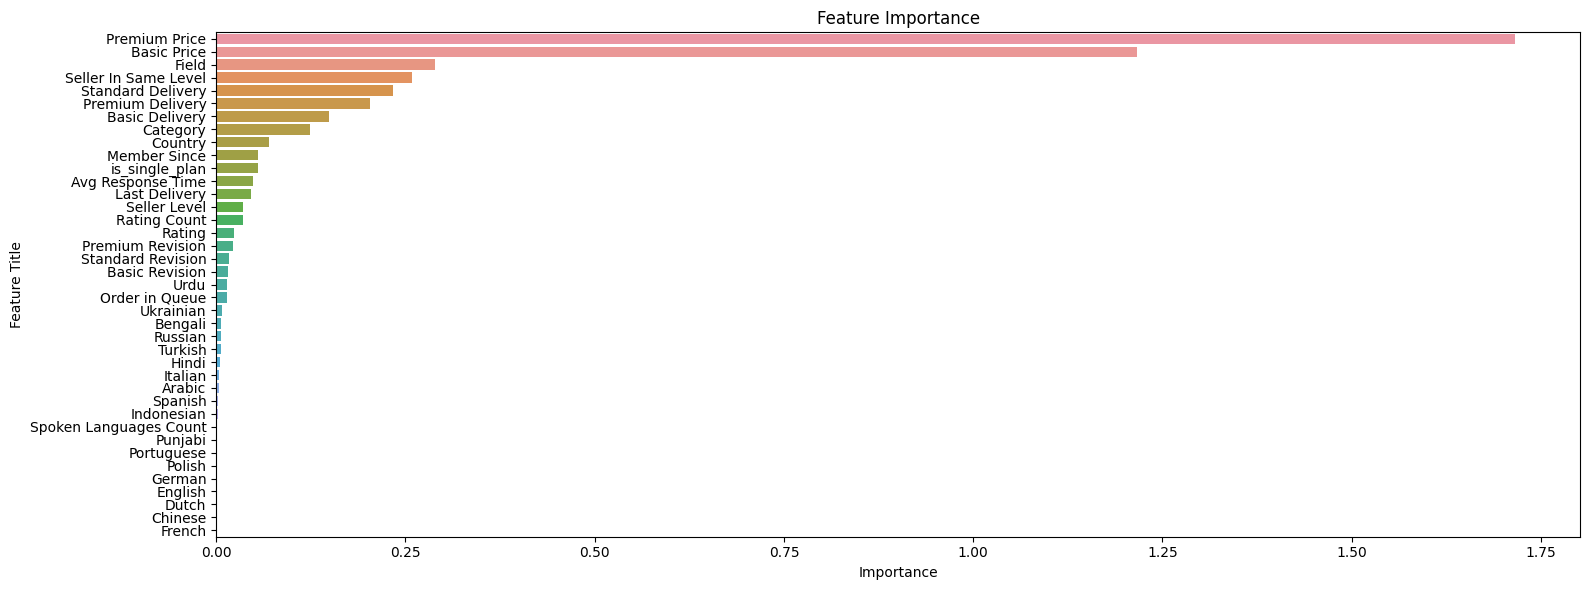

In [27]:
mi_df_1 = calculate_mutual_information(df_normalized, target_column='Standard Price')
print(mi_df_1)
plot_mutual_infos(mi_df_1)

In [28]:
df_final_price = drop_least_important_features(df_normalized, mi_df_1,19)

                   Feature  Importance
3     Seller In Same Level    0.219958
1                    Field    0.205317
17           Last Delivery    0.169490
15            Member Since    0.140906
18          Order in Queue    0.124633
0                 Category    0.106660
2             Seller Level    0.101108
13                  Rating    0.090724
16       Avg Response Time    0.050958
14                 Country    0.041208
5           Standard Price    0.034193
4              Basic Price    0.032669
11       Standard Revision    0.028518
6            Premium Price    0.025588
10          Basic Revision    0.016223
8        Standard Delivery    0.013978
7           Basic Delivery    0.013295
9         Premium Delivery    0.011172
12        Premium Revision    0.011162
29                 Italian    0.010281
28              Indonesian    0.007895
31              Portuguese    0.007563
34                 Spanish    0.007167
33                 Russian    0.006824
25                  Frenc

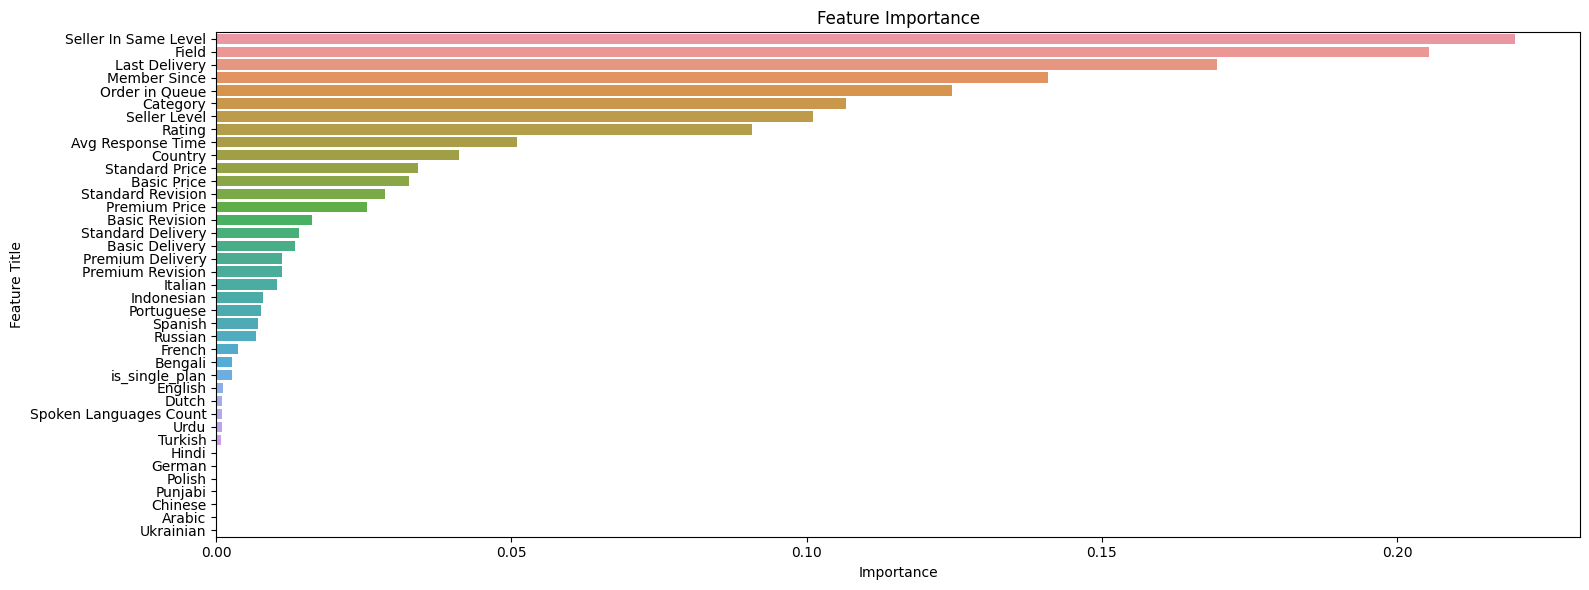

In [29]:
mi_df_2 = calculate_mutual_information(df_normalized, target_column='Rating Count')
print(mi_df_2)
plot_mutual_infos(mi_df_2)

In [30]:
df_final_count = drop_least_important_features(df_normalized, mi_df_2, 13)

In [31]:
df_final_price.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8640 entries, 0 to 8639
Data columns (total 21 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Category              8640 non-null   float64
 1   Field                 8640 non-null   float64
 2   Seller Level          8640 non-null   float64
 3   Seller In Same Level  8640 non-null   float64
 4   Basic Price           8640 non-null   float64
 5   Standard Price        8640 non-null   float64
 6   Premium Price         8640 non-null   float64
 7   Basic Delivery        8640 non-null   float64
 8   Standard Delivery     8640 non-null   float64
 9   Premium Delivery      8640 non-null   float64
 10  Basic Revision        8640 non-null   float64
 11  Standard Revision     8640 non-null   float64
 12  Premium Revision      8640 non-null   float64
 13  Rating                8640 non-null   float64
 14  Rating Count          8640 non-null   float64
 15  Country              

In [32]:
df_final_count.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8640 entries, 0 to 8639
Data columns (total 27 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Category              8640 non-null   float64
 1   Field                 8640 non-null   float64
 2   Seller Level          8640 non-null   float64
 3   Seller In Same Level  8640 non-null   float64
 4   Basic Price           8640 non-null   float64
 5   Standard Price        8640 non-null   float64
 6   Premium Price         8640 non-null   float64
 7   Basic Delivery        8640 non-null   float64
 8   Standard Delivery     8640 non-null   float64
 9   Premium Delivery      8640 non-null   float64
 10  Basic Revision        8640 non-null   float64
 11  Standard Revision     8640 non-null   float64
 12  Premium Revision      8640 non-null   float64
 13  Rating                8640 non-null   float64
 14  Rating Count          8640 non-null   float64
 15  Country              

In [34]:
def plot_correlation_heatmap(df, exclude_columns=None):
    numeric_cols = df.select_dtypes(include=['number'])

    if exclude_columns:
        numeric_cols = numeric_cols.drop(columns=exclude_columns)

    corr_matrix = numeric_cols.corr()

    plt.figure(figsize=(24, 16))
    sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
    plt.title("Correlation Matrix Heatmap")
    plt.show()

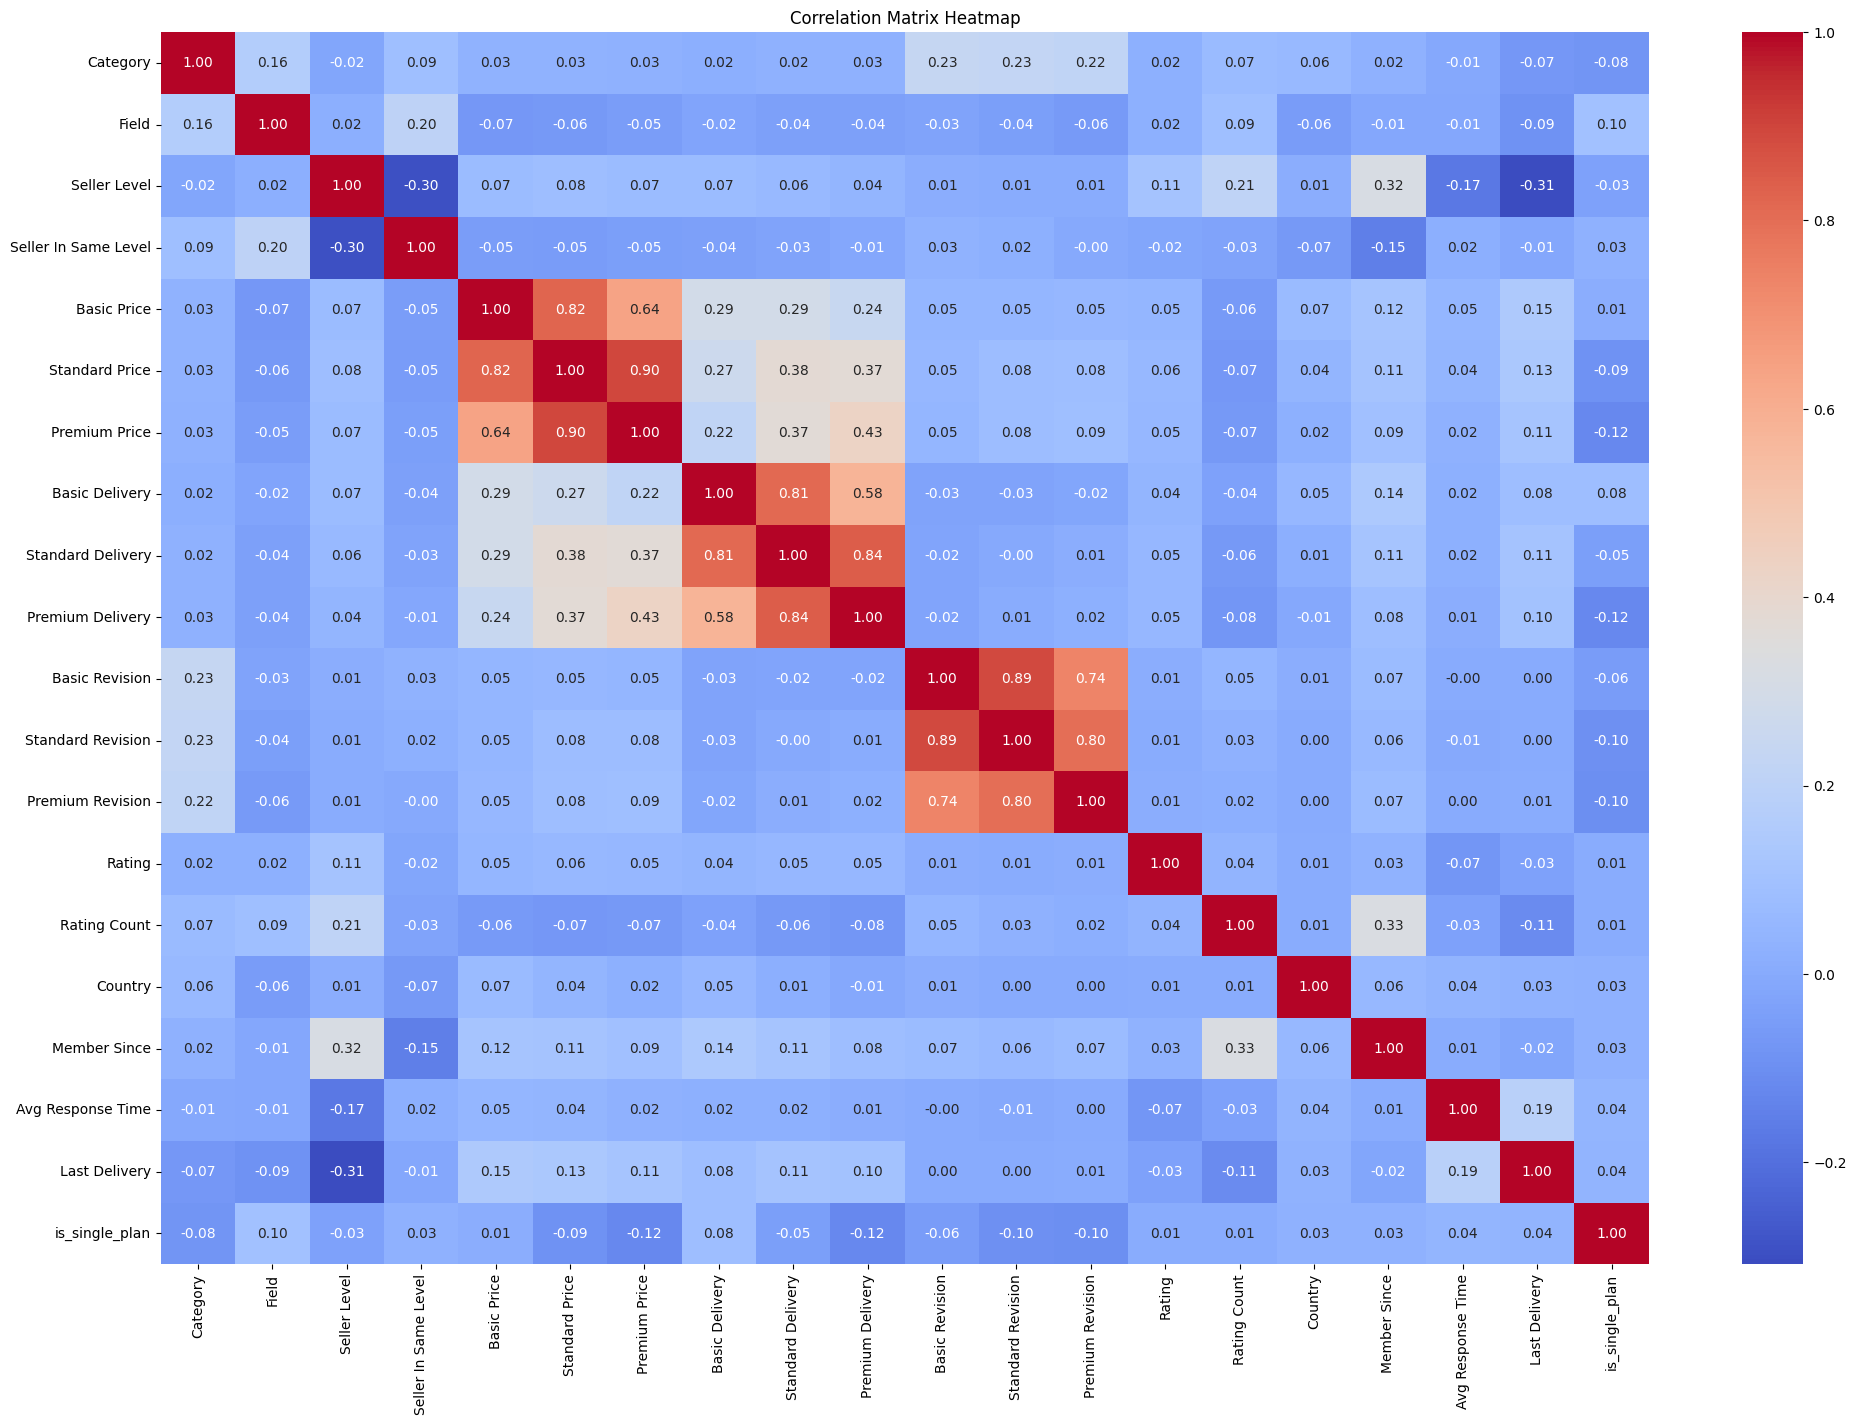

In [35]:
plot_correlation_heatmap(df_final_price, ["Urdu"])

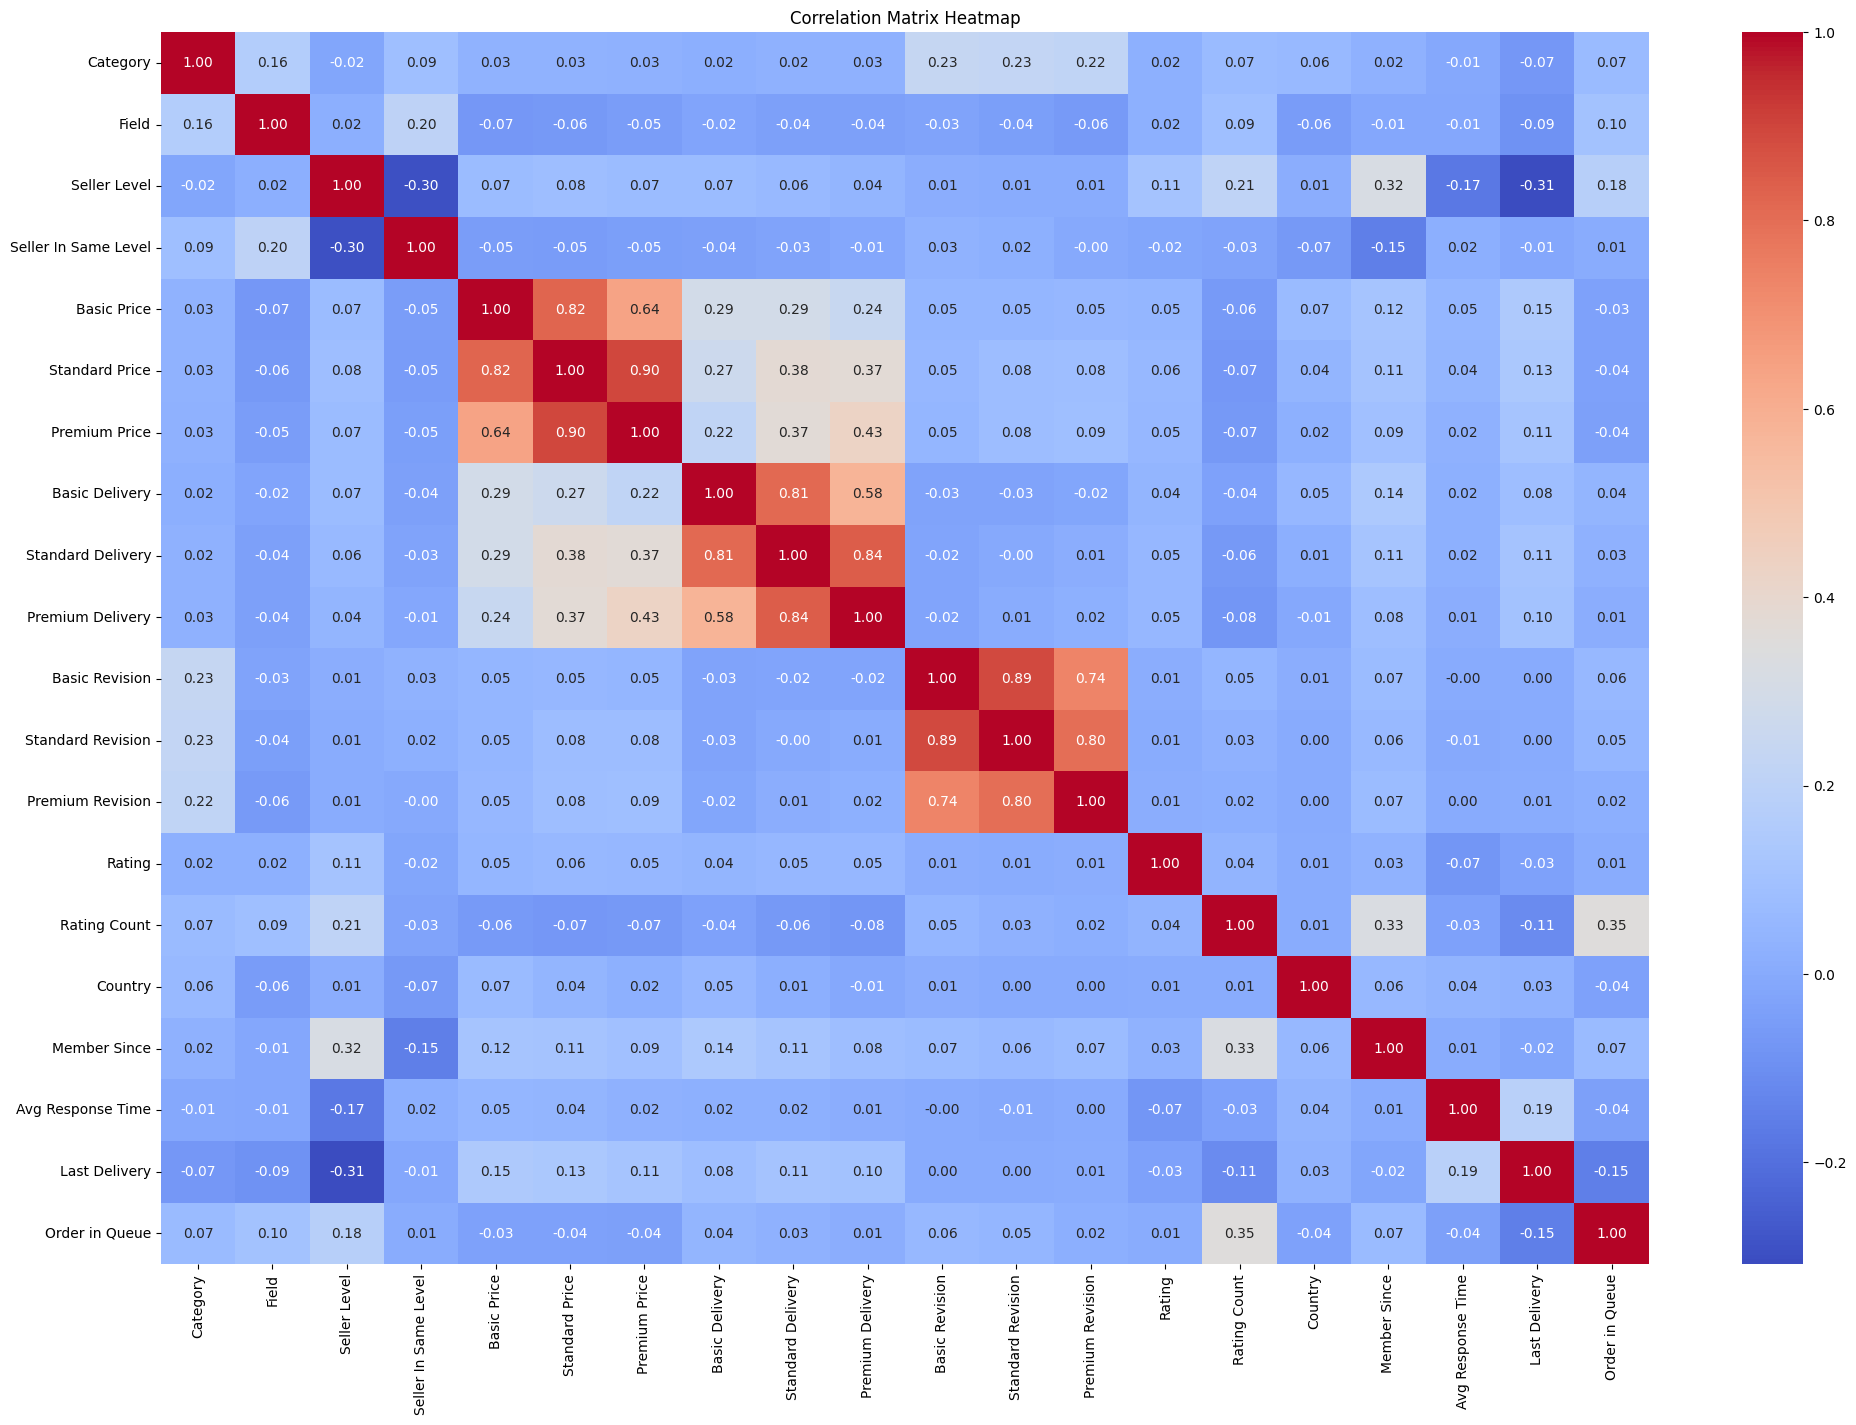

In [36]:
plot_correlation_heatmap(df_final_count, ['French','Indonesian','Spanish','Portuguese','Italian','Russian','Bengali'])

# Part 3: Dimensionaly Reduction

In [37]:
def apply_pca(df, variance_ratio, random_state,target_column):
    print(f'in pca the variance ratio is {variance_ratio}')
    df_copy = df.copy()

    target = df_copy[target_column]
    df_copy = df_copy.drop(columns=[target_column])

    pca = PCA(n_components=variance_ratio, random_state=random_state)

    df_pca = pd.DataFrame(pca.fit_transform(df_copy))

    if (variance_ratio < 1):
        print (f'pca dimontions after pca : {df_pca.shape[1]}')
    else:
        print(f'Total explained variance: {sum(pca.explained_variance_ratio_)}')
    df_pca[target_column] = target.values
    return df_pca

In [38]:
print(df_final_price.shape)

(8640, 21)


In [40]:
df_pca_2d_price = apply_pca(df_final_price, 2, 10,"Standard Price")
df_pca_95_price = apply_pca(df_final_price, 0.95, 10, "Standard Price")

in pca the variance ratio is 2
Total explained variance: 0.28994687903984573
in pca the variance ratio is 0.95
pca dimontions after pca : 16


In [41]:
df_pca_2d_count = apply_pca(df_final_count, 2, 10,"Rating Count")
df_pca_95_count = apply_pca(df_final_count, 0.95, 10,"Rating Count")

in pca the variance ratio is 2
Total explained variance: 0.24466021277985817
in pca the variance ratio is 0.95
pca dimontions after pca : 20


# Part 4: Evaluation metrics

Our task is regression and we use `R2 Score` and `MSE` as evaluataion metrics.     
**Reasons for Choosing R² Score and MSE**     

- R² Score:

    - **Goodness of Fit:** It provides a clear measure of how well the independent variables explain the variability of the dependent variable.
    - **Comparability:** Allows comparison between models by showing the proportion of variance explained by each model.
    - **Interpretability:** It is intuitive and easy to interpret, as it directly relates to the proportion of explained variance.
- MSE:
    - **Error Magnitude:** Directly measures the average magnitude of the errors in the predictions, providing insight into the accuracy of the model.
    - **Penalization of Large Errors:** By squaring the errors, MSE places more weight on larger errors, which can be particularly useful if large errors are particularly undesirable in your project.
    - **Optimization:** Many machine learning algorithms, including linear regression and neural networks, optimize for MSE during training, making it a natural choice for evaluation.

# Part 5 : Model Training

In [42]:
X = df_final_price.drop(columns=['Standard Price'])
y = df_final_price['Standard Price']
X_train_price, X_test_price, y_train_price, y_test_price = train_test_split(X, y, test_size=0.2, random_state=10)

In [43]:
X = df_final_count.drop(columns=['Rating Count'])
y = df_final_price['Rating Count']
X_train_count, X_test_count, y_train_count, y_test_count = train_test_split(X, y, test_size=0.2, random_state=10)

In [44]:
def plot_training_history(history):
    plt.plot(history.history["loss"], label="Train Loss")
    plt.plot(history.history["val_loss"], label="Validation Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Mean Squared Error")
    plt.legend()
    plt.title("Training and Validation Loss")
    plt.show()

In [45]:
def evaluate_regression_model(model,X_test, y_test, model_name):
    y_pred = model.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    print(f"{model_name} R² score: {r2:.4f}")
    
    plt.scatter(y_test, y_pred)
    plt.xlabel("Actual Standard Price")
    plt.ylabel("Predicted Standard Price")
    plt.title(f"Actual vs Predicted Standard Price - {model_name}")
    plt.show()

## Linear Regression

In [46]:
def train_linear_regression(X_train, y_train):

    lr_model = LinearRegression()

    param_grid = {'fit_intercept': [True, False],}

    grid_search = GridSearchCV(lr_model, param_grid, cv=5, scoring='neg_mean_squared_error')
    grid_search.fit(X_train, y_train)

    best_lr_model = grid_search.best_estimator_
    print(f'best mse was : {- grid_search.best_score_}')
    print(f"Best hyperparameters: {grid_search.best_params_}")

    return best_lr_model

### Linear Regression for Standard Price Target

best mse was : 0.09344512496614173
Best hyperparameters: {'fit_intercept': False}
Linear Regression R² score: 0.8853


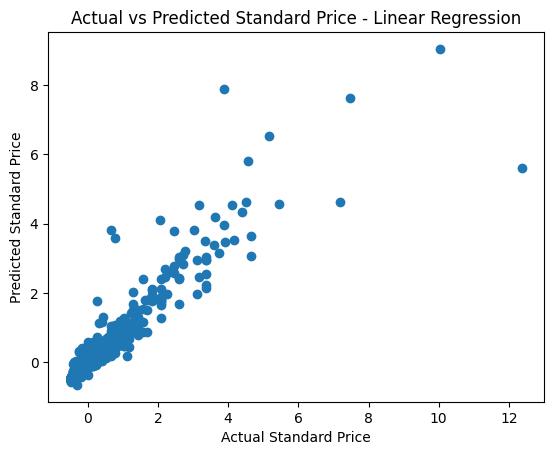

In [47]:
ln_model = train_linear_regression(X_train_price, y_train_price)
evaluate_regression_model(ln_model, X_test_price, y_test_price, "Linear Regression")

### Linear Regression for Rating Count Target

best mse was : 0.8485049663342143
Best hyperparameters: {'fit_intercept': False}
Linear Regression R² score: 0.2522


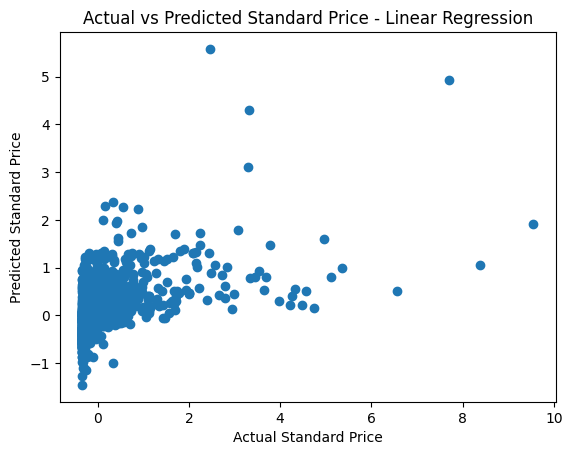

In [48]:
ln_model = train_linear_regression(X_train_count, y_train_count)
evaluate_regression_model(ln_model, X_test_count, y_test_count, "Linear Regression")

## KNN Regression

In [49]:
def train_knn_regression(X_train, y_train):

    knn_regressor = KNeighborsRegressor()

    param_grid = {
        'n_neighbors': [10,11,12,13,14],
        'weights': ['uniform', 'distance'],
        'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']
    }

    grid_search = GridSearchCV(knn_regressor, param_grid, cv=5, scoring='neg_mean_squared_error')
    grid_search.fit(X_train, y_train)

    best_knn_model = grid_search.best_estimator_
    best_params = grid_search.best_params_

    print(f'Best score: {- grid_search.best_score_:.4f}')
    print(f'Best hyperparameters: {best_params}')

    return best_knn_model

### KNN Regression for Standard Price Target

Best score: 0.1921
Best hyperparameters: {'algorithm': 'auto', 'n_neighbors': 10, 'weights': 'distance'}
KNN Regressor R² score: 0.7924


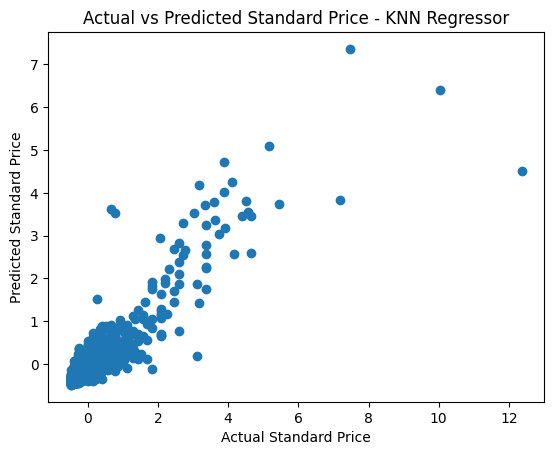

In [50]:
knn_model = train_knn_regression(X_train_price, y_train_price)
evaluate_regression_model(knn_model, X_test_price, y_test_price, "KNN Regressor")

### KNN Regression for Rating Count Target

Best score: 0.8321
Best hyperparameters: {'algorithm': 'ball_tree', 'n_neighbors': 10, 'weights': 'distance'}
KNN Regressor R² score: 0.2944


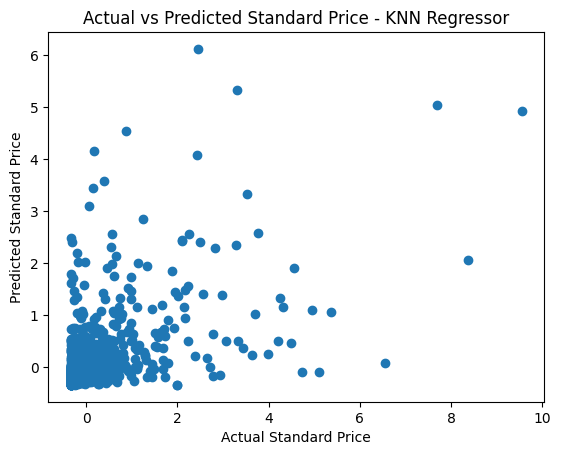

In [51]:
knn_model = train_knn_regression(X_train_count, y_train_count)
evaluate_regression_model(knn_model, X_test_count, y_test_count, "KNN Regressor")

## SVR

### SVR for Rating Count

In [65]:
from sklearn.svm import SVR

def train_svr_regression(X_train, y_train):
    svr_regressor = SVR()

    param_grid = {
        "kernel": ["linear", "poly", "rbf", "sigmoid"],
        "C": [0.1, 1, 10],
        "gamma": ["scale", "auto"],
        "degree": [2, 3],
    }

    grid_search = GridSearchCV(svr_regressor, param_grid, cv=5, scoring='neg_mean_squared_error')
    grid_search.fit(X_train, y_train)

    best_svr_model = grid_search.best_estimator_
    best_params = grid_search.best_params_

    print(f'Best score: {- grid_search.best_score_:.4f}')
    print(f'Best hyperparameters: {best_params}')

    return best_svr_model

Best score: 0.8296
Best hyperparameters: {'C': 10, 'degree': 2, 'gamma': 'auto', 'kernel': 'rbf'}
SVR R² score: 0.3712


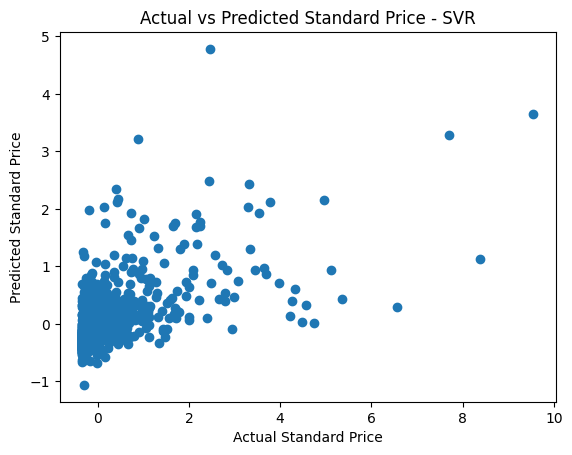

In [66]:
svr_model = train_svr_regression(X_train_count, y_train_count)
evaluate_regression_model(svr_model, X_test_count, y_test_count, "SVR")

## Neural Network

`Adam` is a popular optimizer for neural networks because:

1. Adaptive Learning Rates: It computes individual learning rates for different parameters.
2. Momentum: It incorporates the moving average of the gradient to speed up convergence.
3. Efficiency: It works well with large datasets and high-dimensional spaces.
4. Little Memory Requirements: It's computationally efficient with a small memory footprint.

Adam combines the benefits of two other extensions of stochastic gradient descent, AdaGrad and RMSProp, making it effective for problems with noisy or sparse gradients.

### Neural Network Architecture:
1. Input Layer:

-   Dense Layer (128 units, ReLU activation):
    - Input dimension: Number of features in X_train.
    - Activation function: Rectified Linear Unit (ReLU).
    - This layer processes the input features.
2. Hidden Layers:

-   Dense Layer (256 units, ReLU activation):

    - Activation function: ReLU.
    - Introduces non-linearity and learns complex patterns in the data.
-   Dropout Layer (0.3):

    - Dropout is a regularization technique that randomly sets a fraction of input units to zero during training to prevent overfitting.
    - Dropout rate: 30% (0.3).
    -  Dense Layer (256 units, ReLU activation):

-   Activation function: ReLU.
    - Another layer for learning deeper representations.

-   Dropout Layer (0.3):
    - Dropout rate: 30% (0.3).

-   Dense Layer (128 units, ReLU activation):
    - Activation function: ReLU.
    - Adds more capacity to the model for learning intricate patterns in the data.

-   Dropout Layer (0.3):
    - Dropout rate: 30% (0.3).
3. Output Layer:

-   Dense Layer (1 unit, Linear activation):
    - Activation function: Linear (default).
    - Single output unit for regression tasks, predicting a continuous numerical value.

**Summary:**
- Total Layers: 7 (1 input layer, 5 hidden layers, 1 output layer).
- Activation Functions: ReLU for all hidden layers, and linear for the output layer (which is typical for regression tasks).
- Dropout Layers: Used after each dense layer (except the output layer) with a dropout rate of 30% to prevent overfitting by randomly dropping connections during training.
- Optimizer: Adam optimizer with a specified learning rate (learning_rate parameter).
- Loss Function: Mean Squared Error (MSE), suitable for regression tasks where the goal is to minimize the squared difference between predicted and actual values.
- Explanation:
This neural network architecture is designed for regression tasks, where the goal is to predict a continuous numerical output. The use of multiple dense layers with ReLU activations allows the network to learn hierarchical representations of the input data, while dropout layers help prevent overfitting by regularizing the model during training.

The model is trained using the Adam optimizer, which is effective for handling large datasets and adjusting learning rates dynamically. The training progress is monitored through the validation data (if provided) to evaluate performance metrics such as MSE and R² score.

In [54]:
def train_and_evaluate_nn(X_train, y_train, X_val=None, y_val=None, epochs=50, learning_rate=0.001):
    number_of_features = X_train.shape[1]

    model = Sequential()

    model.add(Dense(units=128, activation='relu', input_dim=number_of_features))

    model.add(Dense(units=256, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(units=256, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(units=128, activation='relu'))
    model.add(Dropout(0.3))

    model.add(Dense(units=1))

    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mean_squared_error')

    model.summary()

    history = model.fit(X_train, y_train, epochs=epochs, batch_size=32,
                        validation_data=(X_val, y_val) if X_val is not None and y_val is not None else None)
    
    y_val_pred = model.predict(X_val)
    val_mse = mean_squared_error(y_val, y_val_pred)
    r2 = r2_score(y_val, y_val_pred)
    print(f"Validation MSE: {val_mse:.4f}")
    print(f"Validation R2: {r2:.4f}")

    plot_training_history(history)


    return model

### Neural Network for Standard Price Target

c:\Python311\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │         2,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 134,529 (525.50 KB)

 Trainable params: 134,529 (525.50 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
216/216 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.3926 - val_loss: 0.1832
Epoch 2/50
216/216 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.2454 - val_loss: 0.0969
Epoch 3/50
216/216 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1591 - val_loss: 0.1279
Epoch 4/50
216/216 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1713 - val_loss: 0.1401
Epoch 5/50
216/216 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1591 - val_loss: 0.0949
Epoch 6/50
216/216 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.1399 - val_loss: 0.1028
Epoch 7/50
216/216 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1085 - val_loss: 0.1045
Epoch 8/50
216/216 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1232 - val_loss: 0.0995
Epoch 9/50
216/216 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1196 - val_loss: 0.1133
Epoch 10/50
216/216 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1135 - val_loss: 0.1056
Epoch 11/50
216/216 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1133 - val_loss: 0.1300
Epoch 12/50
216/216 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

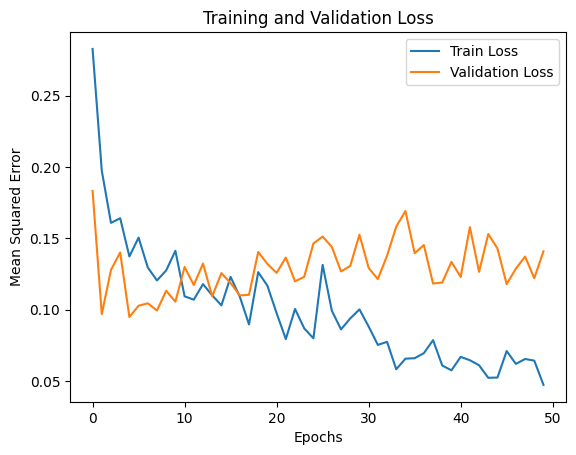

In [55]:
trained_model = train_and_evaluate_nn(X_train_price, y_train_price, X_test_price, y_test_price)

### Neural Network for Rating Count Target

c:\Python311\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_5 (Dense)                 │ (None, 128)            │         3,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 135,297 (528.50 KB)

 Trainable params: 135,297 (528.50 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
216/216 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.8441 - val_loss: 0.4140
Epoch 2/50
216/216 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.3121 - val_loss: 0.3776
Epoch 3/50
216/216 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.6636 - val_loss: 0.4071
Epoch 4/50
216/216 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.7184 - val_loss: 0.4262
Epoch 5/50
216/216 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.6826 - val_loss: 0.4132
Epoch 6/50
216/216 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7280 - val_loss: 0.4020
Epoch 7/50
216/216 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.7872 - val_loss: 0.4183
Epoch 8/50
216/216 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.7948 - val_loss: 0.4215
Epoch 9/50
216/216 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6483 - val_loss: 0.4725
Epoch 10/50
216/216 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5378 - val_loss: 0.4347
Epoch 11/50
216/216 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.6170 - val_loss: 0.4522
Epoch 12/50
216/216 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

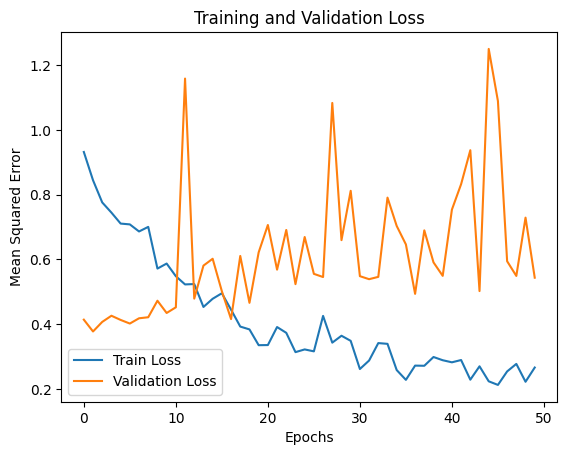

In [56]:
trained_model = train_and_evaluate_nn(X_train_count, y_train_count, X_test_count, y_test_count)

Based on result we get from models, all models perform very good on Standard Price,Although linear regression performs better that others.      
Linear Regression : 0.88       
KNN Regressor : 0.79      
Neural Network : 0.79     
On Rating Count Linear Regression and KNN performs nearly same but Neural Network performs extremely poorly.                      
Linear Regression : 0.25        
KNN Regressor : 0.29                     
Neural Network : 0.02                
I also run another model (SVR) foe Rating Count and get very better result than others (R2 score = 0.37). but still not so good in compare with Standard Price.

# Part 6: Feature Analysis

### For Rating Count Target

In [57]:
X = df_pca_2d_count.drop(columns=['Rating Count'])
y = df_pca_2d_count['Rating Count']
X_train_pca_2d_count, X_test_pca_2d_count, y_train_pca_2d_count, y_test_pca_2d_count = train_test_split(X, y, test_size=0.2, random_state=10)

In [58]:
X = df_pca_95_count.drop(columns=['Rating Count'])
y = df_pca_95_count['Rating Count']
X_train_pca_95_count, X_test_pca_95_count, y_train_pca_95_count, y_test_pca_95_count = train_test_split(X, y, test_size=0.2, random_state=10)

Best score: 1.1262
Best hyperparameters: {'algorithm': 'brute', 'n_neighbors': 14, 'weights': 'uniform'}
KNN Regressor R² score: -0.1301


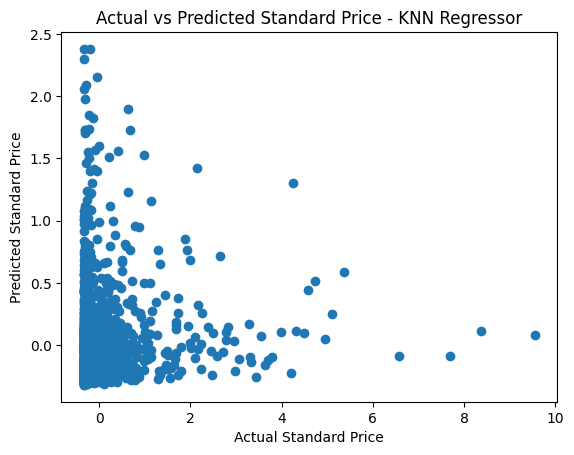

In [59]:
knn_model = train_knn_regression(X_train_pca_2d_count, y_train_pca_2d_count)
evaluate_regression_model(knn_model, X_test_pca_2d_count, y_test_pca_2d_count, "KNN Regressor")

best mse was : 0.8495788193804469
Best hyperparameters: {'fit_intercept': False}
KNN Regressor R² score: 0.2522


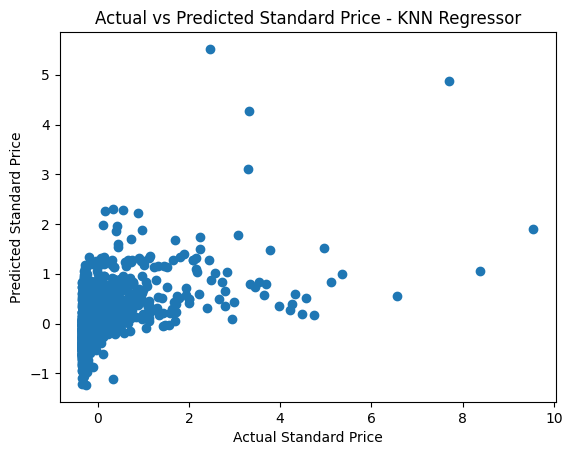

In [60]:
knn_model = train_linear_regression(X_train_pca_95_count, y_train_pca_95_count)
evaluate_regression_model(knn_model, X_test_pca_95_count, y_test_pca_95_count, "KNN Regressor")

### For Standard Price

In [61]:
X = df_pca_2d_price.drop(columns=['Standard Price'])
y = df_pca_2d_price['Standard Price']
X_train_pca_2d_price, X_test_pca_2d_price, y_train_pca_2d_price, y_test_pca_2d_price = train_test_split(X, y, test_size=0.2, random_state=10)

In [62]:
X = df_pca_95_price.drop(columns=['Standard Price'])
y = df_pca_95_price['Standard Price']
X_train_pca_95_price, X_test_pca_95_price, y_train_pca_95_price, y_test_pca_95_price = train_test_split(X, y, test_size=0.2, random_state=10)

best mse was : 0.5840252967064157
Best hyperparameters: {'fit_intercept': False}
Linear Regression R² score: 0.3784


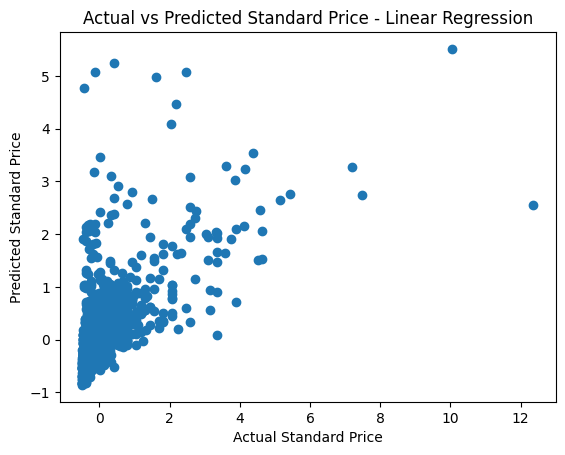

In [63]:
rl_model = train_linear_regression(X_train_pca_2d_price, y_train_pca_2d_price)
evaluate_regression_model(rl_model, X_test_pca_2d_price, y_test_pca_2d_price,"Linear Regression")

best mse was : 0.10197805502700116
Best hyperparameters: {'fit_intercept': False}
Linear Regression R² score: 0.8785


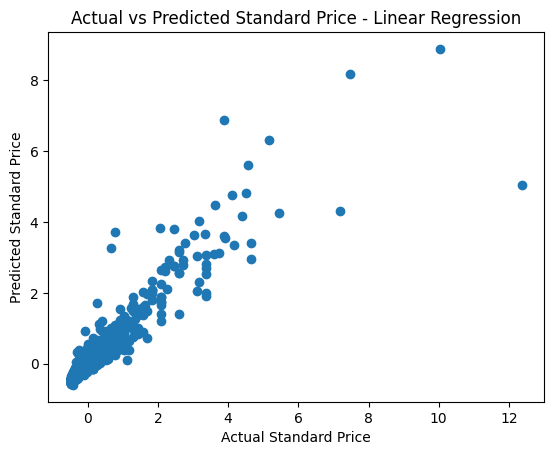

In [64]:
rl_model = train_linear_regression(X_train_pca_95_price, y_train_pca_95_price)
evaluate_regression_model(rl_model, X_test_pca_95_price, y_test_pca_95_price,"Linear Regression")

as you can see after training models on reduction dataframes, performance of model reduces and also as predicted performance of model with dataframe that dimentional reduction retain 95% of original variance is much better that model with dataframe with 2d feature.

When the performance of a model, as measured by metrics like R² score, decreases after applying PCA (Principal Component Analysis) or other feature reduction techniques, several factors could be at play:

- Information Loss:
PCA and Feature Reduction: These techniques aim to reduce the dimensionality of the feature space by capturing the most significant variance in the data.
Potential Issue: If the reduced set of features (components) does not capture enough information relevant to predicting the target variable, the model's performance may suffer.
- Complexity Reduction:
Overfitting Reduction: Feature reduction techniques often help mitigate overfitting by reducing the complexity of the model.
Performance Impact: However, if the original features were contributing useful information that the reduced set does not adequately capture, the model might lose predictive power.

# Overall Report and Discussions

Initially, we attempted web scraping on fiverr.com, but due to site restrictions, we switched to using an API to fetch HTML content via URLs. This method allowed us to gather data without needing a proxy, storing it locally to avoid access limitations. By the end of this phase, we collected 6000 data points, increasing it to 9000 in phase two when we realized more data was needed.

During the exploratory data analysis (EDA) phase, we visualized various plots to gain insights into the dataset.      
During phase 2 we explored two potential target features: Standard Price and Rating Count. After training models on both scenarios, we concluded that Standard Price yielded better predictions consistently across various models. This preference is likely due to the data type collected and the higher correlation of selected features with Standard Price, providing richer information for prediction.






